`ProPublica Recidivism/COMPAS` :<br>
    The COMPAS dataset (Correctional Offender Management Profiling for Alternative Sanctions) is a dataset used for binary classification tasks in the field of criminal justice. The goal is to predict whether a defendant will re-offend within two years of release, based on various demographic and criminal history features.<br>
    Reference Link: https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis

In [2]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative
import matplotlib.pyplot as plt
from aif360.sklearn.datasets import fetch_compas

from IPython.display import Markdown, display

## Load Dataset

In [3]:
X, y = fetch_compas()
X['target'] = y.values

sensitive_attribute = "race"
df = clean_dataset(X,'compas')
y = df['target']
X = df.drop('target', axis=1)

X.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree
0,Male,25 - 45,African-American,0,0,0,"(-0.1, 1.0]",F
1,Male,10-25,African-American,0,0,1,"(1.0, 5.0]",F
2,Male,25 - 45,Caucasian,0,0,0,"(10.0, 15.0]",F
3,Female,25 - 45,Caucasian,0,0,0,"(-0.1, 1.0]",M
4,Male,25 - 45,Caucasian,0,0,0,"(-0.1, 1.0]",F


## Model training and test

In [4]:
num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='target')
model.predict(X_test.iloc[:100, :])

Wall time: 109 ms


array([1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1.])

In [6]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63       745
           1       0.67      0.68      0.67       837

    accuracy                           0.65      1582
   macro avg       0.65      0.65      0.65      1582
weighted avg       0.65      0.65      0.65      1582



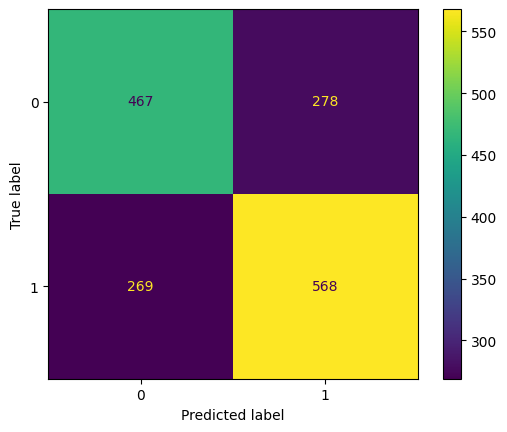

In [7]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [8]:
#Uncomment if you want to find new rules with different support

ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='race',
    freqitem_minsupp = 0.01,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = False
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:00<00:00, 12.08it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 1392/1392 [00:00<00:00, 199469.46it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████| 1050/1050 [00:00<00:00, 9817.21it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 3831/3831 [00:57<00:00, 66.78it/s]

Number of if-thens: 3831


In [16]:

# from facts.utils import load_rules_by_if,save_rules_by_if
# save_rules_by_if("rulesCompas_atomic.data", rules_by_if)

In [8]:
# #### Uncomment if you wish to load rules object from disk

# import dill

# with open("rulesCompas_atomic.data", "rb") as inf:
#     rules_by_if = dill.load(inf)

In [11]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Caucasian"][1][0][1]-e[1]["African-American"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If juv_other_count = 3:
	Protected Subgroup 'African-American', 1.23% covered
		Make juv_other_count = 0 with correctness 0.00%.
	Protected Subgroup 'Caucasian', 2.38% covered
		Make juv_other_count = 0 with correctness 100.00%.
If juv_fel_count = 0, juv_other_count = 3:
	Protected Subgroup 'African-American', 1.23% covered
		Make juv_other_count = 0 with correctness 0.00%.
	Protected Subgroup 'Caucasian', 2.38% covered
		Make juv_other_count = 0 with correctness 100.00%.
If c_charge_degree = F, juv_misd_count = 0, juv_other_count = 1, priors_count = (-0.1, 1.0], sex = Male:
	Protected Subgroup 'African-American', 1.94% covered
		Make juv_other_count = 0 with correctness 0.00%.
		Make c_charge_degree = M, juv_other_count = 0 with correctness 100.00%.
		Make c_charge_degree = M, juv_other_count = 0, priors_count = (1.0, 5.0] with correctness 0.00%.
		Make juv_other_count = 0, priors_count = (1.0, 5.0] with correctness 0.00%.
	Protected Subgroup 'Caucasian', 2.38% covered
		Make juv_othe

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [13]:
num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()
ord_features = []
feature_weights = {'sex':100,	'age_cat':10,	'race':100,	'juv_fel_count':1,	'juv_fel_count':1,	'juv_other_count':1,	'priors_count':1,	'c_charge_degree':1}

features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=False,
    #feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [14]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If juv_other_count = 3:
	Protected Subgroup 'African-American', 1.23% covered out of 3173
		Make juv_other_count = 0 with correctness 0.00%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'Caucasian', 2.38% covered out of 2100
		Make juv_other_count = 0 with correctness 100.00%.
		Aggregate cost of the above recourses = -1.00
	Bias against African-American. Unfairness score = 1.0.
If juv_fel_count = 0, juv_other_count = 3:
	Protected Subgroup 'African-American', 1.23% covered out of 3173
		Make juv_other_count = 0 with correctness 0.00%.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'Caucasian', 2.38% covered out of 2100
		Make juv_other_count = 0 with correctness 100.00%.
		Aggregate cost of the above recourses = -1.00
	Bias against African-American. Unfairness score = 1.0.
If age_cat = 25 - 45, juv_fel_count = 0, juv_other_count = 0, sex = Female:
	Protected Subgroup 'African-American', 3.35% covered out of 3173
		Make age_cat = Greater than 4

## Minimum cost above threshold

In [15]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
)

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If age_cat = 25 - 45:
	Protected Subgroup 'African-American', 61.44% covered out of 3173
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'Caucasian', 61.31% covered out of 2100
		Make age_cat = Greater than 45 with correctness 58.25%.
		Aggregate cost of the above recourses = 1.00
	Bias against African-American. Unfairness score = inf.
If age_cat = 25 - 45, sex = Male:
	Protected Subgroup 'African-American', 57.75% covered out of 3173
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'Caucasian', 57.14% covered out of 2100
		Make age_cat = Greater than 45 with correctness 58.33%.
		Aggregate cost of the above recourses = 1.00
	Bias against African-American. Unfairness score = inf.
If age_cat = 25 - 45, juv_fel_count = 0:
	Protected Subgroup 'African-American', 56.69% covered out of 3173
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup 

## Mean cost above threshold

In [16]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs
))

If age_cat = 25 - 45:
	Protected Subgroup 'African-American', 61.44% covered out of 3173
		No recourses for this subgroup!
	Protected Subgroup 'Caucasian', 61.31% covered out of 2100
		Make age_cat = Greater than 45 with correctness 58.25%.
	Bias against African-American. Unfairness score = inf.
If age_cat = 25 - 45, sex = Male:
	Protected Subgroup 'African-American', 57.75% covered out of 3173
		No recourses for this subgroup!
	Protected Subgroup 'Caucasian', 57.14% covered out of 2100
		Make age_cat = Greater than 45 with correctness 58.33%.
	Bias against African-American. Unfairness score = inf.
If age_cat = 25 - 45, juv_fel_count = 0:
	Protected Subgroup 'African-American', 56.69% covered out of 3173
		No recourses for this subgroup!
	Protected Subgroup 'Caucasian', 60.12% covered out of 2100
		Make age_cat = Greater than 45 with correctness 59.41%.
	Bias against African-American. Unfairness score = inf.
If c_charge_degree = F, juv_misd_count = 0, juv_other_count = 0, sex = Male:
	

## Number above threshold

In [17]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["race"] == sg).sum() for sg in X["race"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If age_cat = 10-25, c_charge_degree = F, juv_other_count = 1, sex = Male:
	Protected Subgroup 'African-American', 4.05% covered out of 3173
		Make age_cat = Greater than 45, juv_other_count = 0 with correctness 86.96%.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_other_count = 0 with correctness 86.96%.
		Aggregate cost of the above recourses = -2.00
	Protected Subgroup 'Caucasian', 4.76% covered out of 2100
		Make age_cat = 25 - 45, juv_other_count = 0 with correctness 50.00%.
		Make age_cat = 25 - 45, c_charge_degree = M, juv_other_count = 0 with correctness 87.50%.
		Make age_cat = Greater than 45, juv_other_count = 0 with correctness 87.50%.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_other_count = 0 with correctness 87.50%.
		Make c_charge_degree = M, juv_other_count = 0 with correctness 50.00%.
		Make juv_other_count = 0 with correctness 50.00%.
		Aggregate cost of the above recourses = -6.00
	Bias against African-American. Unfairness score = 4.
If ag

In [19]:
rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="race", params=params)

100%|██████████| 1011/1011 [00:23<00:00, 42.49it/s]


In [ ]:
save_rules_by_if("rulesCompas_cumulative.data", rules_with_cumulative)